<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Prepare-input-file-for-GLIPH2" data-toc-modified-id="Prepare-input-file-for-GLIPH2-5">Prepare input file for GLIPH2</a></span></li><li><span><a href="#GLIPH2-output" data-toc-modified-id="GLIPH2-output-6">GLIPH2 output</a></span></li><li><span><a href="#circle-plots" data-toc-modified-id="circle-plots-7">circle plots</a></span></li><li><span><a href="#matrix-of-samples-and-GLIPH-output" data-toc-modified-id="matrix-of-samples-and-GLIPH-output-8">matrix of samples and GLIPH output</a></span></li></ul></div>

# Dependencies

In [1]:
library(randomcoloR)
library(igraph)
library(ggraph)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



# Functions

In [2]:
circlepack.reads.fx <- function(inputfile, sample_id_DNA){
    
    sample_df <- inputfile[inputfile$samplename == sample_id_DNA,]
  
    type_tab <- as.data.frame(table(sample_df$Type), stringsAsFactors = F)
    if(nrow(type_tab) != 0){    
        cluster_tab <- type_tab[type_tab$Freq > 1,]
    } else {
        cluster_tab <- type_tab 
    }    
    
# if there is a cluster, group cdr3s and use sum of reads
    if(nrow(cluster_tab) != 0){    
        cluster_tab$typereads <- NA
        for(j in 1:nrow(cluster_tab)){
            mytype <- cluster_tab$Var1[j]
            mytypereads <- sum(sample_df$cloneCount[which(sample_df$Type == mytype)])
            cluster_tab$typereads[j] <- mytypereads
        }
#clean up cluster_tab
        cluster_tab <- cluster_tab[, c("Var1", "typereads")]
        colnames(cluster_tab) <- c("name", "size")
    }
    
# Make edge df
    type_cdr3 <- sample_df[, c("Type", "nSeqCDR3")]
    colnames(type_cdr3) <- c("from", "to")
#if no clusters, edge df is octamer_cdr3 df and all octamers will be replaced by sample_id
    if(nrow(cluster_tab) == 0) {
        myedge <- type_cdr3
        myedge[,"from"] <- unique(sample_df$samplename)
    }
    
# if there is a cluster, make a list of sample_id and clusters
    if(nrow(cluster_tab) != 0){
        myclusters <- cbind.data.frame(NA,cluster_tab$name, stringsAsFactors = F)
        colnames(myclusters) <- c("from", "to")
        myclusters$from <- unique(sample_df$samplename)
# replace types < 2 sequences with sample_id
        type_cdr3$from[!type_cdr3$from %in% cluster_tab$name] <- unique(sample_df$samplename)
        myedge <- rbind(myclusters, type_cdr3)   
    }

# get cdr3 and reads    
    cdr3_freq <- sample_df[, c("nSeqCDR3", "cloneCount")]
    colnames(cdr3_freq) <- c("name", "size")

#bind all and cleanup
# get sample frequency        
    sample_tab <- as.data.frame(table(sample_df$samplename), stringsAsFactors = F)
    colnames(sample_tab) <- c("name", "size")

#bind all and cleanup
    myvertex <- rbind(sample_tab, cdr3_freq)
                      
# if there is a cluster, include it to vertex
    if(nrow(cluster_tab) != 0){
        myvertex <- rbind(myvertex, cluster_tab)
    }

# first row is NA so remove it
    myvertex <- myvertex[!is.na(myvertex$name),]
    myvertex$size <- as.numeric(myvertex$size)
    
# Make a type variable for colors
    myvertex$type <- NA
    myvertex$type[1] <- "samplename"
    myvertex$type[myvertex$name %in% cdr3_freq$name] <- "CDR3"
    myvertex$type[is.na(myvertex$type)] <- myvertex$name[is.na(myvertex$type)] 


    myvertex$group <- NA
    myvertex$group[myvertex$type == "samplename"] <- "samplename"
    myvertex$group[myvertex$type == "CDR3"] <- "CDR3"
    myvertex$group[!myvertex$type %in% c("CDR3", "samplename")] <- "Type"
    
     if(nrow(cluster_tab) != 0){
        myColors <- distinctColorPalette(nrow(cluster_tab))
        myColors <- c("white", # color samplename white
                     rep("#ededed",nrow(myvertex[myvertex$type == "CDR3",])), #color all cdr3 light gray
                     myColors)
        names(myColors) <- myvertex$type
    } else{
         myColors <- c("white", 
                       rep("#ededed",nrow(myvertex[myvertex$type == "CDR3",])))    
         names(myColors) <- myvertex$type
     }
    
mygraph <- graph_from_data_frame(myedge, vertices = myvertex)  
     
    alphapal <- c("CDR3" = 1,"Type" = 0.4, "samplename" = 0)
    circlep <- ggraph(mygraph, layout = 'circlepack', weight = size) + 
    geom_node_circle(aes(fill = type, alpha = group)) +
    theme_void() + scale_fill_manual(values = myColors) +
    scale_alpha_manual(values = alphapal)
   
    
    pdf(file = paste0(plotpath,sample_id_DNA,"_gliph_circles.pdf"),
        width = 15, 
        height = 15,
        useDingbats = FALSE)
    print(circlep)
    dev.off()
}

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Manifests/"

In [4]:
mountpath <- "/Users/anabbi/Desktop/H4H/INDICATE/GLIPH/input/"

# Main

In [5]:
metadata <- read.csv(file.path(datapath,"IND_estimate_metadata_IHC_trb_tmb.csv"),header = T, stringsAsFactors = F, 
                     check.names = F)

# Prepare input file for GLIPH2

Add in all GLIPHinput.txt in one file

In [6]:
filelist <- list.files(mountpath, pattern = "GLIPHinput.txt")

In [7]:
all.files <- lapply(filelist, function(f){ read.table(paste0(mountpath,f), sep = "\t", header = TRUE,
                                                           stringsAsFactors = F)})

In [8]:
filenames <- gsub("CLONES_TRB", "", filelist)
filenames <- gsub("_DNA.*", "", filenames)

In [9]:
filelst <- mapply(cbind, all.files, "Subject"=filenames, SIMPLIFY=F)

In [10]:
gliph.inputdf <- as.data.frame(do.call(rbind, filelst))

In [11]:
gliph.inputdf[ gliph.inputdf$CDR3b == "CASSLYTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG",]

,CDR3b,TRBV,TRBJ,Counts,Subject
,<chr>,<chr>,<chr>,<int>,<chr>
852,CASSLYTGELFFGEGSRLTVLGKEAVGAPESSERAGWAEVSSCPTLRGAVLRGAAG,TRBV11-3,TRBJ2-2P,15,ICT-06520026C0012D_T


In [12]:
table(gliph.inputdf$TRBJ)


 TRBJ1-1  TRBJ1-2  TRBJ1-3  TRBJ1-4  TRBJ1-5  TRBJ1-6  TRBJ2-1  TRBJ2-2 
    1110      870      249      318      495      294     1030      473 
TRBJ2-2P  TRBJ2-3  TRBJ2-4  TRBJ2-5  TRBJ2-6  TRBJ2-7 
      21      665       51      425      100     1006 

In [13]:
gliph.inputdf$CDR3a <- NA

In [14]:
head(gliph.inputdf)

,CDR3b,TRBV,TRBJ,Counts,Subject,CDR3a
,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>
1,CASSYSGGYTF,TRBV6-5,TRBJ1-2,227,ICT-06520001B0024D_T,NA
2,CASSPDTGGFTEAFF,TRBV7-9,TRBJ1-1,214,ICT-06520001B0024D_T,NA
3,CASRLTGGNTEAFF,TRBV7-2,TRBJ1-1,214,ICT-06520001B0024D_T,NA
4,CASSADLAGGYTQYF,TRBV7-2,TRBJ2-3,198,ICT-06520001B0024D_T,NA
5,CASSSGTGFQPQHF,TRBV7-2,TRBJ1-5,173,ICT-06520001B0024D_T,NA
6,CASTRVLSYNEQFF,TRBV11-2,TRBJ2-1,143,ICT-06520001B0024D_T,NA


In [15]:
gliph.inputdf <- gliph.inputdf[, c("CDR3b","TRBV", "TRBJ", "CDR3a", "Subject", "Counts")]

In [16]:
gliph.inputdf <- gliph.inputdf[gliph.inputdf$Subject %in% metadata$sample_id_DNA,]

In [17]:
length(unique(gliph.inputdf$Subject))

[1] 45

In [18]:
write.table(gliph.inputdf, file = paste0(datapath, "GLIPH/IND_GLIPH2_input.txt"), col.names = FALSE, row.names = FALSE,
            sep = "\t", quote = F)

# GLIPH2 output

In [19]:
gliph2 <- read.csv(file.path(datapath,"GLIPH/P2409_WKR0TLACRD_ind_gliph2_refv1_CD48.csv"),header = T, stringsAsFactors = F, 
                     check.names = F)

In [20]:
colnames(gliph2)

[1] "index"              "pattern"            "Fisher_score"      
 [4] "number_subject"     "number_unique_cdr3" "final_score"       
 [7] "hla_score"          "vb_score"           "expansion_score"   
[10] "length_score"       "cluster_size_score" "type"              
[13] "ulTcRb"             "TcRb"               "V"                 
[16] "J"                  "TcRa"               "Sample"            
[19] "Freq"               "HLA-A"              "HLA-B"             
[22] "HLA-C"              "HLA-DPA1"           "HLA-DPB1"          
[25] "HLA-DQA1"           "HLA-DQB1"           "HLA-DRB1"          
[28] "HLA-DRB3"           "HLA-DRB4"           "HLA-DRB5"

In [21]:
dim(gliph2)

[1] 1799   30

In [22]:
gliph2$cdr_length <- nchar(gliph2$TcRb)

In [23]:
summary(gliph2$cdr_length)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   13.00   15.00   32.17   57.00   61.00 

In [24]:
table(gliph2$J)


 TRBJ1-1  TRBJ1-2  TRBJ1-3  TRBJ1-4  TRBJ1-5  TRBJ1-6  TRBJ2-1  TRBJ2-2 
     200      106       38       19       85       32      160      102 
TRBJ2-2P  TRBJ2-3  TRBJ2-5  TRBJ2-6  TRBJ2-7 
     755       84       45        9      164 

Remove rows with multiple motifs from super long CDR3s

In [25]:
gliph2 <- gliph2[!grepl(" ",gliph2$type),]

In [26]:
head(gliph2)

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,⋯,HLA-C,HLA-DPA1,HLA-DPB1,HLA-DQA1,HLA-DQB1,HLA-DRB1,HLA-DRB3,HLA-DRB4,HLA-DRB5,cdr_length
,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
752,46,YSSY,1.9e-09,7,8,0.00011,1,0.85,0.4,0.4,⋯,-,-,-,-,-,-,-,-,-,18
753,46,YSSY,1.9e-09,7,8,0.00011,1,0.85,0.4,0.4,⋯,-,-,-,-,-,-,-,-,-,20
754,46,YSSY,1.9e-09,7,8,0.00011,1,0.85,0.4,0.4,⋯,-,-,-,-,-,-,-,-,-,18
755,46,YSSY,1.9e-09,7,8,0.00011,1,0.85,0.4,0.4,⋯,-,-,-,-,-,-,-,-,-,21
756,46,YSSY,1.9e-09,7,8,0.00011,1,0.85,0.4,0.4,⋯,-,-,-,-,-,-,-,-,-,14
757,46,YSSY,1.9e-09,7,8,0.00011,1,0.85,0.4,0.4,⋯,-,-,-,-,-,-,-,-,-,15


In [27]:
tmp <- as.data.frame(table(gliph2$type))

In [28]:
dim(tmp)

[1] 456   2

In [30]:
summary(tmp$Freq)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   2.000   2.237   2.000   8.000 

# circle plots

Add motifs to mixcr files

In [31]:
mountpath <- "/Users/anabbi/Desktop/H4H/INDICATE/CapTCR/NovaSeq/ds_ICT/clones/"

In [32]:
flelst <- list.files(mountpath,recursive = TRUE, pattern = "CLONES_TRB")

In [33]:
i <- 1
  for (f in flelst){
    mixcrfle <- read.table(paste0(mountpath, f), header = TRUE, sep = "\t", stringsAsFactors = F, na.strings = c("", "NA"))
    message("mixcr file: ", f)  
    print(dim(mixcrfle))  
    #remove nonproductive seqs  
    mixcr_productivefle <- mixcrfle[!grepl("_",mixcrfle$aaSeqCDR3)& !grepl("[*]",mixcrfle$aaSeqCDR3),]  
    message("mixcr file with only productive seqs: ", f)  
    print(dim(mixcr_productivefle)) 
    
    #recalculate cloneFraction
    mixcr_productivefle$cloneFraction <- NA
    mixcr_productivefle$cloneFraction <- mixcr_productivefle$cloneCount/sum(mixcr_productivefle$cloneCount)
      
    if(i == 1){
      compldfle <- mixcr_productivefle
      compldfle <- cbind(cloneno = row.names(compldfle), 
                         filename = f, 
                         compldfle)
      i <- i + 1   
    }
    else{
      compldfle1 <- mixcr_productivefle
      compldfle1 <- cbind(cloneno = row.names(compldfle1), filename = f, compldfle1)
      compldfle <- rbind(compldfle, compldfle1)
      rm(compldfle1)
    }
  }


mixcr file: CLONES_TRBICT-06520001B0024D_T_DNA_capTCRseq_S63_L002_1600000.txt



[1] 118  35


mixcr file with only productive seqs: CLONES_TRBICT-06520001B0024D_T_DNA_capTCRseq_S63_L002_1600000.txt



[1] 84 35


mixcr file: CLONES_TRBICT-06520004C0016D_T_DNA_capTCRseq_S76_L002_1600000.txt



[1] 372  35


mixcr file with only productive seqs: CLONES_TRBICT-06520004C0016D_T_DNA_capTCRseq_S76_L002_1600000.txt



[1] 283  35


mixcr file: CLONES_TRBICT-06520007C0016D_T_DNA_capTCRseq_S71_L002_1600000.txt



[1] 310  35


mixcr file with only productive seqs: CLONES_TRBICT-06520007C0016D_T_DNA_capTCRseq_S71_L002_1600000.txt



[1] 231  35


mixcr file: CLONES_TRBICT-06520010B0021D_T_DNA_capTCRseq_S66_L002_1600000.txt



[1] 48 35


mixcr file with only productive seqs: CLONES_TRBICT-06520010B0021D_T_DNA_capTCRseq_S66_L002_1600000.txt



[1] 38 35


mixcr file: CLONES_TRBICT-06520011B0021D_T_DNA_capTCRseq_S70_L002_1600000.txt



[1] 12 35


mixcr file with only productive seqs: CLONES_TRBICT-06520011B0021D_T_DNA_capTCRseq_S70_L002_1600000.txt



[1] 11 35


mixcr file: CLONES_TRBICT-06520017C0016D_T_DNA_capTCRseq_S72_L002_1600000.txt



[1]  7 35


mixcr file with only productive seqs: CLONES_TRBICT-06520017C0016D_T_DNA_capTCRseq_S72_L002_1600000.txt



[1]  5 35


mixcr file: CLONES_TRBICT-06520019C0024D_T_DNA_capTCRseq_S77_L002_1600000.txt



[1] 264  35


mixcr file with only productive seqs: CLONES_TRBICT-06520019C0024D_T_DNA_capTCRseq_S77_L002_1600000.txt



[1] 208  35


mixcr file: CLONES_TRBICT-06520026C0012D_T_DNA_capTCRseq_S75_L002_1600000.txt



[1] 56 35


mixcr file with only productive seqs: CLONES_TRBICT-06520026C0012D_T_DNA_capTCRseq_S75_L002_1600000.txt



[1] 49 35


mixcr file: CLONES_TRBICT-06520030C0016D_T_DNA_capTCRseq_S73_L002_1600000.txt



[1]  4 35


mixcr file with only productive seqs: CLONES_TRBICT-06520030C0016D_T_DNA_capTCRseq_S73_L002_1600000.txt



[1]  3 35


mixcr file: CLONES_TRBICT-06520033C0016D_T_DNA_capTCRseq_S79_L002_1600000.txt



[1] 746  35


mixcr file with only productive seqs: CLONES_TRBICT-06520033C0016D_T_DNA_capTCRseq_S79_L002_1600000.txt



[1] 602  35


mixcr file: CLONES_TRBICT-06520034C0016D_T_DNA_capTCRseq_S86_L002_1600000.txt



[1]  1 35


mixcr file with only productive seqs: CLONES_TRBICT-06520034C0016D_T_DNA_capTCRseq_S86_L002_1600000.txt



[1]  1 35


mixcr file: CLONES_TRBICT-06520038B0024D_T_DNA_capTCRseq_S78_L002_1600000.txt



[1] 10 35


mixcr file with only productive seqs: CLONES_TRBICT-06520038B0024D_T_DNA_capTCRseq_S78_L002_1600000.txt



[1]  9 35


mixcr file: CLONES_TRBICT-06520046C0016D_T_DNA_capTCRseq_S83_L002_1600000.txt



[1] 34 35


mixcr file with only productive seqs: CLONES_TRBICT-06520046C0016D_T_DNA_capTCRseq_S83_L002_1600000.txt



[1] 30 35


mixcr file: CLONES_TRBICT-06520049C0019D_T_DNA_capTCRseq_S67_L002_1600000.txt



[1] 22 35


mixcr file with only productive seqs: CLONES_TRBICT-06520049C0019D_T_DNA_capTCRseq_S67_L002_1600000.txt



[1] 18 35


mixcr file: CLONES_TRBICT-06520058C0044D_T_DNA_capTCRseq_S69_L002_1600000.txt



[1] 220  35


mixcr file with only productive seqs: CLONES_TRBICT-06520058C0044D_T_DNA_capTCRseq_S69_L002_1600000.txt



[1] 170  35


mixcr file: CLONES_TRBICT-06520059B0021D_T_DNA_capTCRseq_S85_L002_1600000.txt



[1] 43 35


mixcr file with only productive seqs: CLONES_TRBICT-06520059B0021D_T_DNA_capTCRseq_S85_L002_1600000.txt



[1] 31 35


mixcr file: CLONES_TRBICT-06520063C0041D_T_DNA_capTCRseq_S84_L002_1600000.txt



[1] 24 35


mixcr file with only productive seqs: CLONES_TRBICT-06520063C0041D_T_DNA_capTCRseq_S84_L002_1600000.txt



[1] 17 35


mixcr file: CLONES_TRBICT-06520067C0016D_T_DNA_capTCRseq_S81_L002_1600000.txt



[1] 36 35


mixcr file with only productive seqs: CLONES_TRBICT-06520067C0016D_T_DNA_capTCRseq_S81_L002_1600000.txt



[1] 29 35


mixcr file: CLONES_TRBICT-06520068B0021D_T_DNA_capTCRseq_S68_L002_1600000.txt



[1] 17 35


mixcr file with only productive seqs: CLONES_TRBICT-06520068B0021D_T_DNA_capTCRseq_S68_L002_1600000.txt



[1] 16 35


mixcr file: CLONES_TRBICT-06520070C0016D_T_DNA_capTCRseq_S82_L002_1600000.txt



[1]  6 35


mixcr file with only productive seqs: CLONES_TRBICT-06520070C0016D_T_DNA_capTCRseq_S82_L002_1600000.txt



[1]  3 35


mixcr file: CLONES_TRBICT-06520071C0018D_T_DNA_capTCRseq_S80_L002_1600000.txt



[1] 42 35


mixcr file with only productive seqs: CLONES_TRBICT-06520071C0018D_T_DNA_capTCRseq_S80_L002_1600000.txt



[1] 31 35


mixcr file: CLONES_TRBICT-06520074C0018D_T_DNA_capTCRseq_S61_L002_1600000.txt



[1] 69 35


mixcr file with only productive seqs: CLONES_TRBICT-06520074C0018D_T_DNA_capTCRseq_S61_L002_1600000.txt



[1] 48 35


mixcr file: CLONES_TRBICT-06520078C0026D_T_DNA_capTCRseq_S64_L002_1600000.txt



[1] 1289   35


mixcr file with only productive seqs: CLONES_TRBICT-06520078C0026D_T_DNA_capTCRseq_S64_L002_1600000.txt



[1] 1020   35


mixcr file: CLONES_TRBICT-06520080B0021D_T_DNA_capTCRseq_S74_L002_1600000.txt



[1] 16 35


mixcr file with only productive seqs: CLONES_TRBICT-06520080B0021D_T_DNA_capTCRseq_S74_L002_1600000.txt



[1] 13 35


mixcr file: CLONES_TRBICT-06520082C0016D_T_DNA_capTCRseq_S62_L002_1600000.txt



[1] 469  35


mixcr file with only productive seqs: CLONES_TRBICT-06520082C0016D_T_DNA_capTCRseq_S62_L002_1600000.txt



[1] 361  35


mixcr file: CLONES_TRBICT-06520090C0019D_T_DNA_capTCRseq_S65_L002_1600000.txt



[1] 2266   35


mixcr file with only productive seqs: CLONES_TRBICT-06520090C0019D_T_DNA_capTCRseq_S65_L002_1600000.txt



[1] 1796   35


mixcr file: CLONES_TRBICT-6201764804-02_T_DNA_capTCRseq_S39_L002_1600000.txt



[1] 19 35


mixcr file with only productive seqs: CLONES_TRBICT-6201764804-02_T_DNA_capTCRseq_S39_L002_1600000.txt



[1] 18 35


mixcr file: CLONES_TRBICT-6201764818-01_T_DNA_capTCRseq_S47_L002_1600000.txt



[1] 25 35


mixcr file with only productive seqs: CLONES_TRBICT-6201764818-01_T_DNA_capTCRseq_S47_L002_1600000.txt



[1] 18 35


mixcr file: CLONES_TRBICT-6201764824-02_T_DNA_capTCRseq_S41_L002_1600000.txt



[1] 65 35


mixcr file with only productive seqs: CLONES_TRBICT-6201764824-02_T_DNA_capTCRseq_S41_L002_1600000.txt



[1] 50 35


mixcr file: CLONES_TRBICT-6201815172-01_T_DNA_capTCRseq_S48_L002_1600000.txt



[1] 384  35


mixcr file with only productive seqs: CLONES_TRBICT-6201815172-01_T_DNA_capTCRseq_S48_L002_1600000.txt



[1] 299  35


mixcr file: CLONES_TRBICT-6201815273-02_T_DNA_capTCRseq_S60_L002_1600000.txt



[1] 23 35


mixcr file with only productive seqs: CLONES_TRBICT-6201815273-02_T_DNA_capTCRseq_S60_L002_1600000.txt



[1] 16 35


mixcr file: CLONES_TRBICT-6201855900-02_T_DNA_capTCRseq_S31_L002_1600000.txt



[1] 43 35


mixcr file with only productive seqs: CLONES_TRBICT-6201855900-02_T_DNA_capTCRseq_S31_L002_1600000.txt



[1] 28 35


mixcr file: CLONES_TRBICT-6202116713-02_T_DNA_capTCRseq_S59_L002_1600000.txt



[1] 322  35


mixcr file with only productive seqs: CLONES_TRBICT-6202116713-02_T_DNA_capTCRseq_S59_L002_1600000.txt



[1] 243  35


mixcr file: CLONES_TRBICT-6202116728-02_T_DNA_capTCRseq_S40_L002_1600000.txt



[1]  8 35


mixcr file with only productive seqs: CLONES_TRBICT-6202116728-02_T_DNA_capTCRseq_S40_L002_1600000.txt



[1]  4 35


mixcr file: CLONES_TRBICT-6202116735-01_T_DNA_capTCRseq_S54_L002_1600000.txt



[1]  2 35


mixcr file with only productive seqs: CLONES_TRBICT-6202116735-01_T_DNA_capTCRseq_S54_L002_1600000.txt



[1]  1 35


mixcr file: CLONES_TRBICT-6202116747_T_DNA_capTCRseq_S50_L002_1600000.txt



[1]  7 35


mixcr file with only productive seqs: CLONES_TRBICT-6202116747_T_DNA_capTCRseq_S50_L002_1600000.txt



[1]  2 35


mixcr file: CLONES_TRBICT-6202218209-01_T_DNA_capTCRseq_S58_L002_1600000.txt



[1] 691  35


mixcr file with only productive seqs: CLONES_TRBICT-6202218209-01_T_DNA_capTCRseq_S58_L002_1600000.txt



[1] 545  35


mixcr file: CLONES_TRBICT-6202255794-02_T_DNA_capTCRseq_S37_L002_1600000.txt



[1] 211  35


mixcr file with only productive seqs: CLONES_TRBICT-6202255794-02_T_DNA_capTCRseq_S37_L002_1600000.txt



[1] 151  35


mixcr file: CLONES_TRBICT-6202261663-02_T_DNA_capTCRseq_S57_L002_1600000.txt



[1] 11 35


mixcr file with only productive seqs: CLONES_TRBICT-6202261663-02_T_DNA_capTCRseq_S57_L002_1600000.txt



[1] 10 35


mixcr file: CLONES_TRBICT-6202277503-02_T_DNA_capTCRseq_S35_L002_1600000.txt



[1] 22 35


mixcr file with only productive seqs: CLONES_TRBICT-6202277503-02_T_DNA_capTCRseq_S35_L002_1600000.txt



[1] 18 35


mixcr file: CLONES_TRBICT-6202549619-02_T_DNA_capTCRseq_S33_L002_1600000.txt



[1] 17 35


mixcr file with only productive seqs: CLONES_TRBICT-6202549619-02_T_DNA_capTCRseq_S33_L002_1600000.txt



[1] 13 35


mixcr file: CLONES_TRBICT-6202785779-02_T_DNA_capTCRseq_S32_L002_1600000.txt



[1] 62 35


mixcr file with only productive seqs: CLONES_TRBICT-6202785779-02_T_DNA_capTCRseq_S32_L002_1600000.txt



[1] 50 35


mixcr file: CLONES_TRBICT-6202994429-02_T_DNA_capTCRseq_S56_L002_1600000.txt



[1] 60 35


mixcr file with only productive seqs: CLONES_TRBICT-6202994429-02_T_DNA_capTCRseq_S56_L002_1600000.txt



[1] 44 35


mixcr file: CLONES_TRBICT-6203065383-03_T_DNA_capTCRseq_S46_L002_1600000.txt



[1] 338  35


mixcr file with only productive seqs: CLONES_TRBICT-6203065383-03_T_DNA_capTCRseq_S46_L002_1600000.txt



[1] 267  35


mixcr file: CLONES_TRBICT-6203065392-02_T_DNA_capTCRseq_S43_L002_1600000.txt



[1] 604  35


mixcr file with only productive seqs: CLONES_TRBICT-6203065392-02_T_DNA_capTCRseq_S43_L002_1600000.txt



[1] 489  35


mixcr file: CLONES_TRBICT-6203065431-03_T_DNA_capTCRseq_S38_L002_1600000.txt



[1] 24 35


mixcr file with only productive seqs: CLONES_TRBICT-6203065431-03_T_DNA_capTCRseq_S38_L002_1600000.txt



[1] 19 35


mixcr file: CLONES_TRBICT-6203065432-01_T_DNA_capTCRseq_S34_L002_1600000.txt



[1] 12 35


mixcr file with only productive seqs: CLONES_TRBICT-6203065432-01_T_DNA_capTCRseq_S34_L002_1600000.txt



[1]  6 35


mixcr file: CLONES_TRBICT-6203065440-02_T_DNA_capTCRseq_S36_L002_1600000.txt



[1]  6 35


mixcr file with only productive seqs: CLONES_TRBICT-6203065440-02_T_DNA_capTCRseq_S36_L002_1600000.txt



[1]  5 35


mixcr file: CLONES_TRBICT-6203065456-02_T_DNA_capTCRseq_S52_L002_1600000.txt



[1] 806  35


mixcr file with only productive seqs: CLONES_TRBICT-6203065456-02_T_DNA_capTCRseq_S52_L002_1600000.txt



[1] 626  35


mixcr file: CLONES_TRBICT-6204179150-01_T_DNA_capTCRseq_S55_L002_1600000.txt



[1] 90 35


mixcr file with only productive seqs: CLONES_TRBICT-6204179150-01_T_DNA_capTCRseq_S55_L002_1600000.txt



[1] 74 35


mixcr file: CLONES_TRBICT-6501799176-02_T_DNA_capTCRseq_S53_L002_1600000.txt



[1] 36 35


mixcr file with only productive seqs: CLONES_TRBICT-6501799176-02_T_DNA_capTCRseq_S53_L002_1600000.txt



[1] 26 35


mixcr file: CLONES_TRBICT-6502064156-02_T_DNA_capTCRseq_S51_L002_1600000.txt



[1] 18 35


mixcr file with only productive seqs: CLONES_TRBICT-6502064156-02_T_DNA_capTCRseq_S51_L002_1600000.txt



[1] 13 35


mixcr file: CLONES_TRBICT-6502168706_T_DNA_capTCRseq_S42_L002_1600000.txt



[1] 141  35


mixcr file with only productive seqs: CLONES_TRBICT-6502168706_T_DNA_capTCRseq_S42_L002_1600000.txt



[1] 109  35


mixcr file: CLONES_TRBICT-6502553313-02_T_DNA_capTCRseq_S49_L002_1600000.txt



[1] 244  35


mixcr file with only productive seqs: CLONES_TRBICT-6502553313-02_T_DNA_capTCRseq_S49_L002_1600000.txt



[1] 179  35


In [34]:
compldfle$samplename <- gsub("CLONES_TRB", "", compldfle$filename)
compldfle$samplename <- gsub("_DNA.*", "",compldfle$samplename)
compldfle$cloneno <- formatC(compldfle$cloneno, 
                             width=nchar(max(as.numeric(compldfle$cloneno))), flag="0")

In [35]:
length(unique(compldfle$samplename))

[1] 54

In [36]:
compldfle <- compldfle[compldfle$samplename %in% metadata$sample_id_DNA,]

In [37]:
length(unique(compldfle$samplename))

[1] 45

Add type from gliph to complefle

In [38]:
compldfle$Type <- NA
compldfle$Type <- gliph2$type[match(compldfle$aaSeqCDR3,gliph2$TcRb)]

In [39]:
inputfile <- compldfle

In [40]:
sample_id_DNA <- "ICT-6202994429-02_T"

In [41]:
compldfle[ compldfle$aaSeqCDR3 == "CASSVTSGRTNEQFF",]

,cloneno,filename,cloneId,cloneCount,cloneFraction,clonalSequence,clonalSequenceQuality,allVHitsWithScore,allDHitsWithScore,allJHitsWithScore,⋯,aaSeqFR1,aaSeqCDR1,aaSeqFR2,aaSeqCDR2,aaSeqFR3,aaSeqCDR3,aaSeqFR4,refPoints,samplename,Type
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<chr>,<chr>
11007,1,CLONES_TRBICT-6202994429-02_T_DNA_capTCRseq_S56_L002_1600000.txt,25,257,0.05547162,TGTGCCAGCAGCGTGACTAGCGGGAGAACTAATGAGCAGTTCTTC,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,TRBV9*00(722.4),TRBD2*00(60),TRBJ2-1*00(199.4),⋯,NA,NA,NA,NA,NA,CASSVTSGRTNEQFF,NA,:::::::::0:-2:14:14:-2:-2:26:30:-7:45:::,ICT-6202994429-02_T,global-S%TSGRTNE


In [42]:
compldfle[ compldfle$aaSeqCDR3 == "CASSVTSGRSNEQFF",]

,cloneno,filename,cloneId,cloneCount,cloneFraction,clonalSequence,clonalSequenceQuality,allVHitsWithScore,allDHitsWithScore,allJHitsWithScore,⋯,aaSeqFR1,aaSeqCDR1,aaSeqFR2,aaSeqCDR2,aaSeqFR3,aaSeqCDR3,aaSeqFR4,refPoints,samplename,Type
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<chr>,<chr>
8124,8,CLONES_TRBICT-6202994429-02_T_DNA_capTCRseq_S56_L002_1600000.txt,53,200,0.04316857,TGTGCCAGCAGCGTAACTTCGGGAAGATCCAATGAGCAGTTCTTC,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,TRBV9*00(693.1),"TRBD1*00(25),TRBD2*00(25)",TRBJ2-1*00(199.3),⋯,NA,NA,NA,NA,NA,CASSVTSGRSNEQFF,NA,:::::::::0:-1:15:19:1:-8:24:29:-6:45:::,ICT-6202994429-02_T,global-SVTSGR%NE


In [44]:
    sample_df <- inputfile[inputfile$samplename == sample_id_DNA,]
  
    type_tab <- as.data.frame(table(sample_df$Type), stringsAsFactors = F)
    if(nrow(type_tab) != 0){    
        cluster_tab <- type_tab[type_tab$Freq > 1,]
    } else {
        cluster_tab <- type_tab 
    }    
    
# if there is a cluster, group cdr3s and use sum of reads
    if(nrow(cluster_tab) != 0){    
        cluster_tab$typereads <- NA
        for(j in 1:nrow(cluster_tab)){
            mytype <- cluster_tab$Var1[j]
            mytypereads <- sum(sample_df$cloneCount[which(sample_df$Type == mytype)])
            cluster_tab$typereads[j] <- mytypereads
        }
#clean up cluster_tab
        cluster_tab <- cluster_tab[, c("Var1", "typereads")]
        colnames(cluster_tab) <- c("name", "size")
    }
    
# Make edge df
    type_cdr3 <- sample_df[, c("Type", "nSeqCDR3")]
    colnames(type_cdr3) <- c("from", "to")
#if no clusters, edge df is octamer_cdr3 df and all octamers will be replaced by sample_id
    if(nrow(cluster_tab) == 0) {
        myedge <- type_cdr3
        myedge[,"from"] <- unique(sample_df$samplename)
    }
    
# if there is a cluster, make a list of sample_id and clusters
    if(nrow(cluster_tab) != 0){
        myclusters <- cbind.data.frame(NA,cluster_tab$name, stringsAsFactors = F)
        colnames(myclusters) <- c("from", "to")
        myclusters$from <- unique(sample_df$samplename)
# replace types < 2 sequences with sample_id
        type_cdr3$from[!type_cdr3$from %in% cluster_tab$name] <- unique(sample_df$samplename)
        myedge <- rbind(myclusters, type_cdr3)   
    }

# get cdr3 and reads    
    cdr3_freq <- sample_df[, c("nSeqCDR3", "cloneCount")]
    colnames(cdr3_freq) <- c("name", "size")

#bind all and cleanup
# get sample frequency        
    sample_tab <- as.data.frame(table(sample_df$samplename), stringsAsFactors = F)
    colnames(sample_tab) <- c("name", "size")

#bind all and cleanup
    myvertex <- rbind(sample_tab, cdr3_freq)
                      
# if there is a cluster, include it to vertex
    if(nrow(cluster_tab) != 0){
        myvertex <- rbind(myvertex, cluster_tab)
    }

# first row is NA so remove it
    myvertex <- myvertex[!is.na(myvertex$name),]
    myvertex$size <- as.numeric(myvertex$size)
    
# Make a type variable for colors
    myvertex$type <- NA
    myvertex$type[1] <- "samplename"
    myvertex$type[myvertex$name %in% cdr3_freq$name] <- "CDR3"
    myvertex$type[is.na(myvertex$type)] <- myvertex$name[is.na(myvertex$type)] 


    myvertex$group <- NA
    myvertex$group[myvertex$type == "samplename"] <- "samplename"
    myvertex$group[myvertex$type == "CDR3"] <- "CDR3"
    myvertex$group[!myvertex$type %in% c("CDR3", "samplename")] <- "Type"
    
     if(nrow(cluster_tab) != 0){
        myColors <- distinctColorPalette(nrow(cluster_tab))
        myColors <- c("white", # color samplename white
                     rep("#ededed",nrow(myvertex[myvertex$type == "CDR3",])), #color all cdr3 light gray
                     myColors)
        names(myColors) <- myvertex$type
    } else{
         myColors <- c("white", 
                       rep("#ededed",nrow(myvertex[myvertex$type == "CDR3",])))    
         names(myColors) <- myvertex$type
     }
    
mygraph <- graph_from_data_frame(myedge, vertices = myvertex)  
     
    alphapal <- c("CDR3" = 1,"Type" = 0.4, "samplename" = 0)
    circlep <- ggraph(mygraph, layout = 'circlepack', weight = size) + 
    geom_node_circle(aes(fill = type, alpha = group)) +
    theme_void() + scale_fill_manual(values = myColors) +
    scale_alpha_manual(values = alphapal)
   

Non-leaf weights ignored



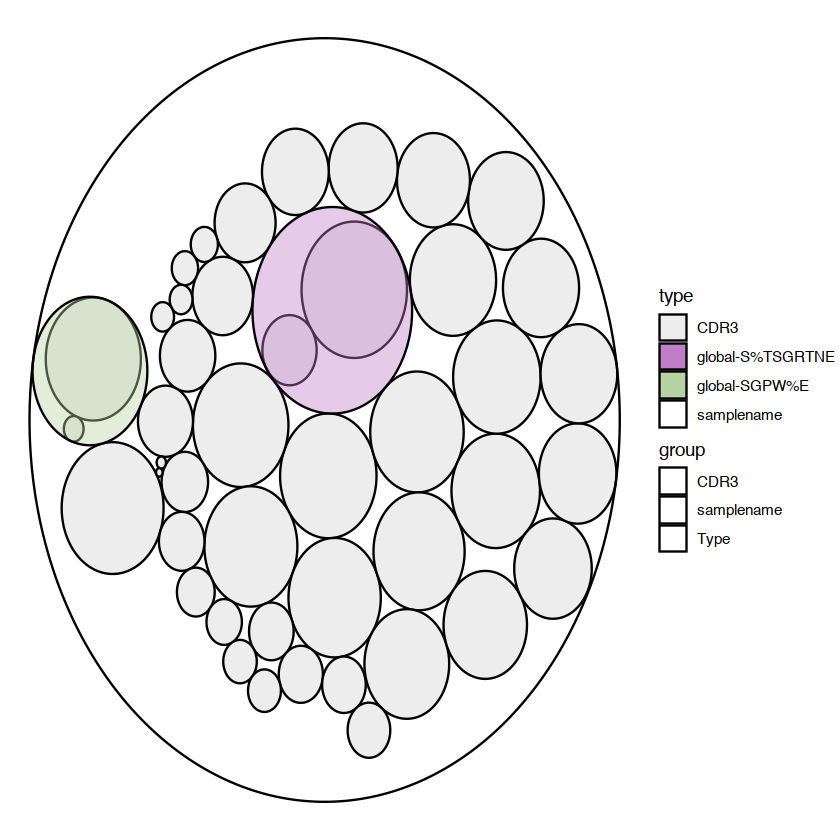

In [45]:
circlep

In [46]:
for(smpl in unique(compldfle$samplename)){
   circlepack.reads.fx(compldfle, smpl) 
}

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf weights ignored

Non-leaf wei

# matrix of samples and GLIPH output

In [47]:
gliph2 <- read.csv(file.path(datapath,"GLIPH/P2409_WKR0TLACRD_ind_gliph2_refv1_CD48.csv"),header = T, stringsAsFactors = F, 
                     check.names = F)

In [48]:
gliph2$cdr_length <- nchar(gliph2$TcRb)

In [49]:
head(gliph2)

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,⋯,HLA-C,HLA-DPA1,HLA-DPB1,HLA-DQA1,HLA-DQB1,HLA-DRB1,HLA-DRB3,HLA-DRB4,HLA-DRB5,cdr_length
,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,CPTL,1.1e-43,10,17,2.4e-05,1,0.99,1,0.25,⋯,-,-,-,-,-,-,-,-,-,60
2,1,CPTL,1.1e-43,10,17,2.4e-05,1,0.99,1,0.25,⋯,-,-,-,-,-,-,-,-,-,60
3,1,CPTL,1.1e-43,10,17,2.4e-05,1,0.99,1,0.25,⋯,-,-,-,-,-,-,-,-,-,59
4,1,CPTL,1.1e-43,10,17,2.4e-05,1,0.99,1,0.25,⋯,-,-,-,-,-,-,-,-,-,60
5,1,CPTL,1.1e-43,10,17,2.4e-05,1,0.99,1,0.25,⋯,-,-,-,-,-,-,-,-,-,58
6,1,CPTL,1.1e-43,10,17,2.4e-05,1,0.99,1,0.25,⋯,-,-,-,-,-,-,-,-,-,59


In [50]:
summary(gliph2$cdr_length)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   13.00   15.00   32.17   57.00   61.00 

Remove rows with multiple motifs from super long CDR3s

In [51]:
gliph2 <- gliph2[!grepl(" ",gliph2$type),]

In [52]:
gliph2 <- gliph2[gliph2$Sample %in% metadata$sample_id_DNA,]

In [53]:
length(unique(gliph2$Sample))

[1] 38

In [54]:
tcr_mat <- matrix(nrow = length(unique(gliph2$Sample)), ncol = length(unique(gliph2$type)),
                 dimnames = list(unique(gliph2$Sample), unique(gliph2$type)))

In [55]:
for( i in 1:nrow(tcr_mat)){
    sampl <- rownames(tcr_mat)[i]
    mygliph <- gliph2[ gliph2$Sample == sampl,]
    tcr_df <- as.data.frame(table(mygliph$type), stringsAsFactors = F)
    tcr_mat[i,] <- tcr_df$Freq[match(colnames(tcr_mat), tcr_df$Var1)]
}

In [56]:
head(tcr_mat)

,motif-YSSY,motif-SMYS,global-SI%GTENQP,global-SQDLG%TE,global-TG%SYNE,motif-LFI,motif-SYPS,global-RG%AGNT,global-SLAGG%DT,motif-PIRD,⋯,global-SHEGVSYNE,global-SPRGEYNE,global-EQGEGQP,global-SQGIQEET,global-SALGDDYG,global-RGQGALFTDT,global-TNPGSGANV,global-SVLPDT,global-SESFGGSYE,global-SQGDTE
ICT-06520033C0016D_T,1,NA,NA,NA,3,1,NA,2,NA,1,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ICT-6502168706_T,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ICT-6203065383-03_T,1,NA,NA,NA,NA,1,NA,NA,2,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2,NA
ICT-06520004C0016D_T,1,NA,NA,NA,NA,NA,3,NA,NA,NA,⋯,NA,NA,2,NA,NA,NA,1,NA,NA,NA
ICT-6203065392-02_T,1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ICT-06520078C0026D_T,2,1,1,NA,NA,NA,NA,NA,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [57]:
write.csv(tcr_mat, file = paste0(datapath, "GLIPH/IND_GLIPH2_TCR_Matrix.csv"), quote = F)